In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from HexClasses import HEX, Fluid
from scipy.optimize import fsolve

### 1. Load data

In [2]:
# initialise HEX
hex = HEX(ri=0.3, ro=0.35, R=0.6, k=397, n=1)

# initialise fluids
fluid1 = Fluid(Cp=470, rho=3100)
fluid2 = Fluid(Cp=500, rho=1000)

In [3]:
# f_type: 0 - parallel, 1 - counter
f_type = 0

if f_type == 0:
    dfs = pd.read_csv("../../py_data/HEXPractice/parallel.csv", header=0)
elif f_type == 1:
    dfs = pd.read_csv("../../py_data/HEXPractice/counter.csv", header=0)

Suppose we only have monitoring data of inlet temeratures:
$T_{1, \text{in}}, T_{2, \text{in}}$,
and mass flow rates:
$\dot{m}_{1}, \dot{m}_{2}$.

In [4]:
T1i = dfs["F1i"]       # Fluid1 (cold) inlet temperature
T1o = dfs["F1o"]       # Fluid1 (cold) outlet temperature
m1 = dfs["F1m"]        # Fluid1 (cold) mass flow rate
T2i = dfs["F2i"]       # Fluid2 (hot) inlet temperature
T2o = dfs["F2o"]       # Fluid2 (hot) outlet temperature
m2 = dfs["F2m"]        # Fluid2 (hot) mass flow rate

fluid1.get_Inlets(T1i, m1)
fluid2.get_Inlets(T2i, m2)
fluid2.get_Prams(hex.Ac2, hex.D2, hex.As2)

### 2. Calculate multiplication of overall heat transfer coeffient and surface area $U A_{s}$  

Heat duty: $\dot{Q} = \dot{m}_{1} Cp_{1} (T_{1, \text{out}} - T_{1, \text{in}}) = \dot{m}_{2} Cp_{2} (T_{2, \text{in}} - T_{2, \text{out}})$.

In [5]:
# get heat duty
Q = m1 * fluid1.Cp * (T1o - T1i)

Log mean temperature difference: $\Delta T_{\text{lm}} = \frac{\Delta T_{1} - \Delta T_{2} }{\ln(\Delta T_{1} / \Delta T_{2} )}$.

$\Delta T_{1}, \Delta T_{2}$ are temperature differences at the same position (depending on flow directions).

In [6]:
# get log mean temperature difference
if f_type == 0:
    dT1 = T2i - T1i
    dT2 = T2o - T1o
elif f_type == 1:
    dT1 = T2o - T1i
    dT2 = T2i - T1o

dTlm = (dT1 - dT2) / np.log(dT1 / dT2)

$U A_{s} = \dot{Q} / F \Delta T_{\text{lm}}$.


The correlation factor $F \approx 0.99937$ for one shell and one tube HEX. The answer should be approximately 100 times of dfs["UA"], which have 100 distributed node and are calculated by average.

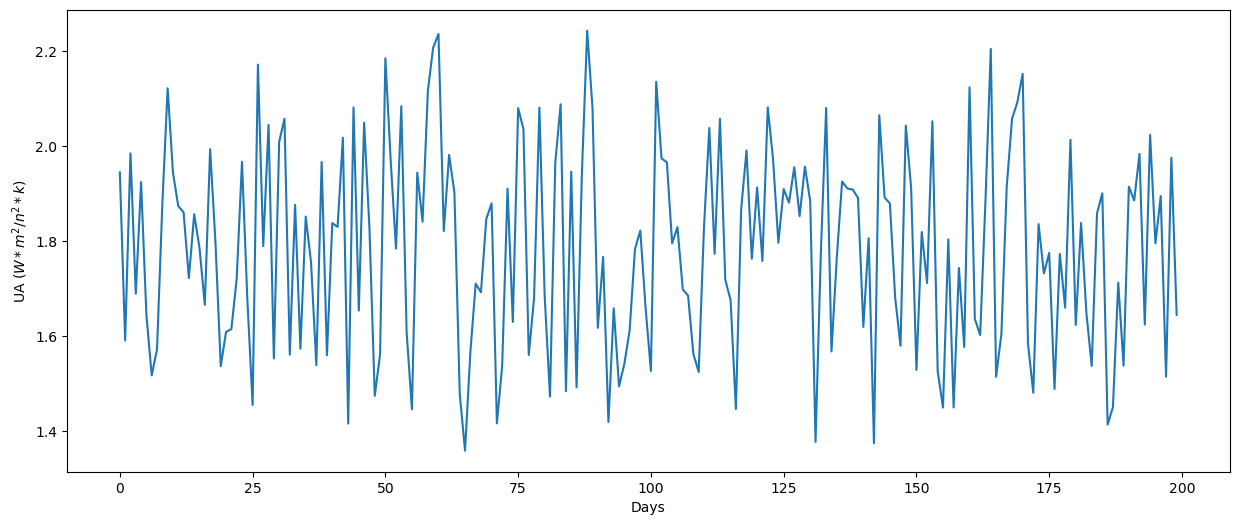

In [7]:
# get UA
UA = Q / (0.99937 * dTlm)

# plot it
plt.figure(figsize=(15, 6))
plt.plot(dfs["UA"].to_numpy())
plt.ylabel("UA ($W*m^2/n^2*k$)")
plt.xlabel("Days")
plt.show()

### 2. Calculate fouling thicknes.

Suppose we only have fouling in tube side (otherwise we cannot solve $\sigma$ with present kowns).
$$R_{\text{total}} = \frac{1}{U A_{s}} = R_{\text{conv}, 1} + R_{f} + \underbrace{R_{\text{wall}}}_{\text{constant}} + \underbrace{R_{\text{conv}, 2}}_{\text{suppose constant}}\\
= \frac{1}{h A_{s}} + \frac{\ln (r_{\text{in}} / (r_{\text{in}} - \sigma))}{2 \pi k_{f} L} + R_{\text{wall}} + \frac{1}{h_{2} A_{s, 2}}
$$

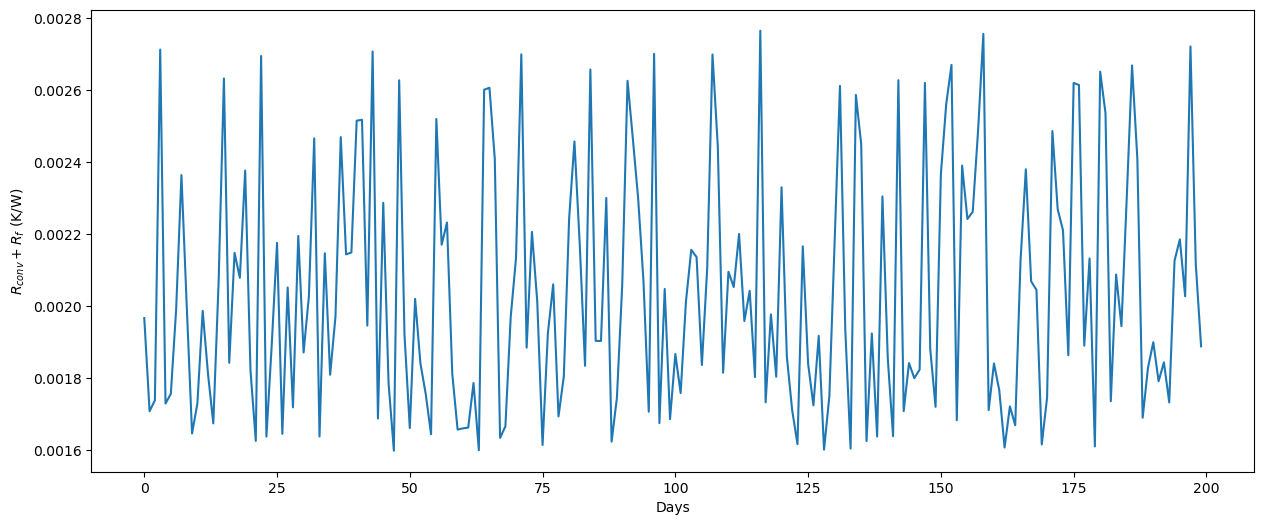

In [8]:
# Get rid of the Rwall and Rconv2
Rflu = 1 / UA - hex.dRwall - fluid2.R

plt.figure(figsize=(15, 6))
plt.plot(Rflu)
plt.ylabel("$R_{conv} + R_{f}$ (K/W)")
plt.xlabel("Days")
plt.show()

$$h = \mathbf{Nu} k_{1} / D, As_{1} = 2 \pi (r_{in} - \sigma) L\\
\Leftarrow \\
Nu = 0.023 \mathbf{Re}^{0.8} \mathbf{Pr}^{0.4} \\
\Leftarrow \\
\mathbf{Re} = D v \rho / \mu,  \mathbf{Pr} = \mu C_{p} / k_{1} \\
\Leftarrow \\
D = 4A_{c} / P = 2 \pi (r_{in} - \sigma), v = \dot{V} / A_{c} = \dot{m} / \pi (r_{in} - \sigma)^2 \rho
$$

Therefore, we just need solve equation to obtain $\sigma$:
$$\underbrace{R_{\text{total}} - R_{\text{wall}} - R_{\text{conv}, 2}}_{\text{kown}}  = \frac{1}{h_{1}(\sigma) As_{1}(\sigma)} + \frac{\ln (r_{\text{in}} / (r_{\text{in}} - \sigma))}{2 \pi k_{1} L} \\
\approx \frac{24.9717}{k_{1} L (C_{p} \mu / k_{1})^{0.4} (\dot{m} / \mu (r_{\text{in}} - \sigma))^{0.8}} + \frac{\ln (r_{\text{in}} / (r_{\text{in}} - \sigma))}{2 \pi k_{f} L}
$$

In [9]:
# define the function, where x = ri - sigma, maybe somehow wrong
# func = lambda x: 24.9717 / (hex.L * fluid1.k * (fluid1.Cp * fluid1.mu / fluid1.k) ** 0.4 * (m1 / (fluid1.mu * x)) ** 0.8) + np.log(hex.ri / x) / (2 * np.pi * 0.2 * hex.L) - Rflu

In [10]:
# define the function of above
def func(sigma):
    rfi = hex.ri - sigma
    Ac1 = np.pi * rfi ** 2
    D1 = 2 * rfi
    As1 = np.pi * D1 * hex.dx
    Vol1 = fluid1.m / fluid1.rho
    v1 = Vol1 / Ac1
    Re = fluid1.get_Re(v1, D1)
    Pr = fluid1.get_Pr()
    Nu = fluid1.get_Nu(Re, Pr)
    h1 = fluid1.get_h(Nu, D1)
    Rf = hex.get_Rf(hex.ri, hex.ri - sigma, 0.2)

    return 1 / (As1 * h1) + Rf - Rflu

In [11]:
guess = (1e-5 / 2) * np.ones(len(dfs))
sigma_sol = fsolve(func, guess)

/home/zdlzdlxs/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


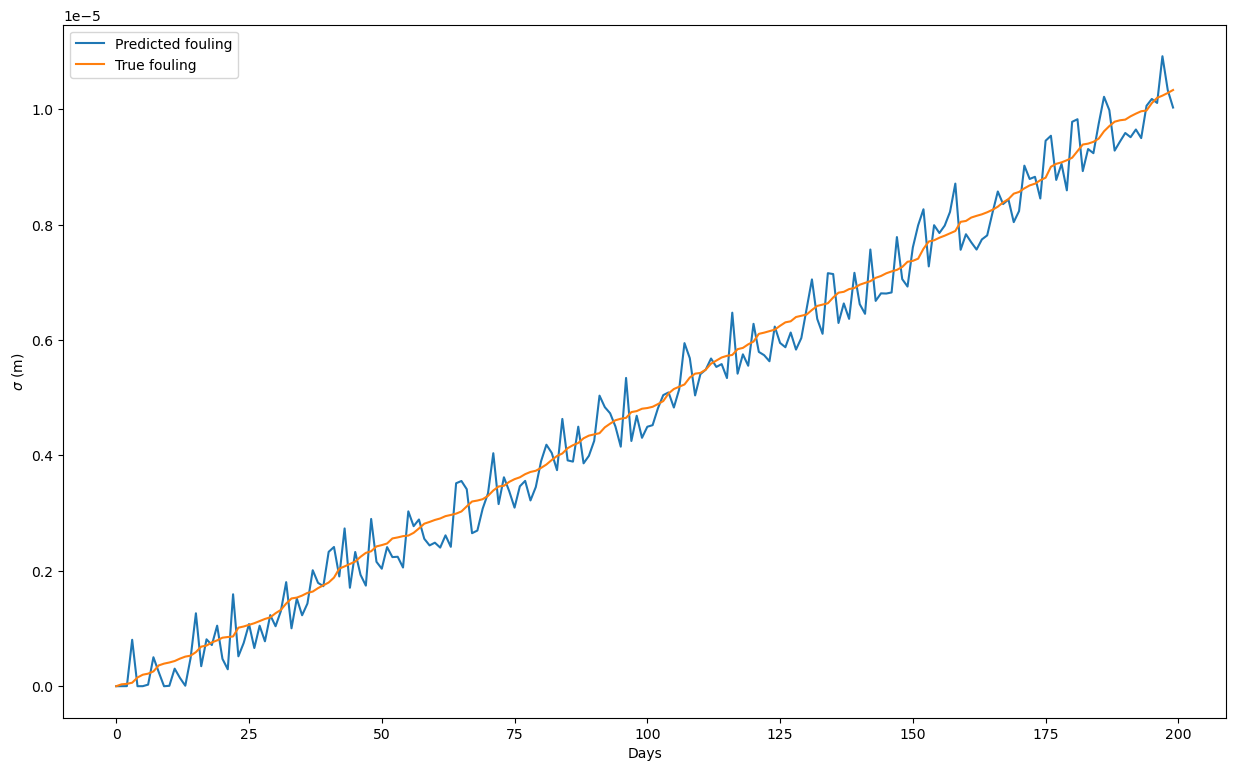

In [12]:
plt.figure(figsize=(15, 9))
plt.plot(sigma_sol, label="Predicted fouling")
plt.plot(dfs["Sigma1"], label="True fouling")
plt.ylabel("$\sigma$ (m)")
plt.xlabel("Days")
plt.legend()
plt.show()